# Playground 1:  Segmentation workflow for sialyltransferase 1

This notebook contains the workflow for sialyltransferase 1, and serves as a starting point for developing a classic segmentation workflow if your data shows similar morphology as sialyltransferase 1.

----------------------------------------

Cell Structure Observations:

* [Sialyltransferase 1](https://www.allencell.org/cell-observations/category/sialyltransferase-1)

----------------------------------------

Key steps of the workflows:

* Auto-Contrast intensity normalization
* 3D Gaussian smoothing 
* Masked-Object Thresholding 
* 3D Spot filter 
* Topology-preserving smoothing
* Size thresholding

In [1]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# function for core algorithm
from aicssegmentation.core.seg_dot import dot_3d_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d
from skimage.morphology import remove_small_objects, binary_closing, ball , dilation   # function for post-processing (size filter)
from aicssegmentation.core.utils import topology_preserving_thinning
from aicssegmentation.core.MO_threshold import MO

## Loading the data

In [2]:
FILE_NAME = '../../data/ST6GAL1/original/3500001289_100X_20170915_25_44_1-Scene-11-P39-E08.czi'

reader = AICSImage(FILE_NAME) 
IMG = reader.data.astype(np.float32)

print(IMG.shape)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(1, 7, 65, 624, 924)


## Preview of the image

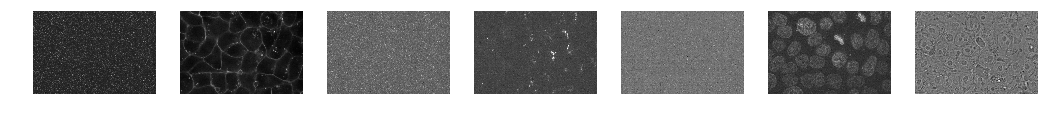

In [23]:
N_CHANNELS = IMG.shape[1]
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS>1:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)

In [5]:
#####################
structure_channel = 3
#####################

struct_img0 = IMG[0,structure_channel,:,:,:].copy()
view(single_fluorescent_view(struct_img0))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

## Image segmentation

### Step 1: Pre-Processing

About selected algorithms and tuned parameters

* **Intensity normalization**: Parameter `intensity_scaling_param` has two options: two values, say `[A, B]`, or single value, say `[K]`. For the first case, `A` and `B` are non-negative values indicating that the full intensity range of the stack will first be cut-off into **[mean - A * std, mean + B * std]** and then rescaled to **[0, 1]**. The smaller the values of `A` and `B` are, the higher the contrast will be. For the second case, `K`>0 indicates min-max Normalization with an absolute intensity upper bound `K` (i.e., anything above `K` will be chopped off and reset as the minimum intensity of the stack) and `K`=0 means min-max Normalization without any intensity bound.

    * Parameter for st6gal1:  `intensity_scaling_param = [9, 19]`


* **Smoothing**: 3D gaussian smoothing with `gaussian_smoothing_sigma = 1`. The large the value is, the more the image will be smoothed. 

In [6]:
################################
## PARAMETER ##
intensity_scaling_param = [9,19]
gaussian_smoothing_sigma = 1
################################
# intensity normalization
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)

# smoothing with gaussian filter
structure_img_smooth = image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)

intensity normalization: normalize into [mean - 9 x std, mean + 19 x std] 
intensity normalization completes


In [5]:
# quickly visualize the image after smoothing
view(single_fluorescent_view(structure_img_smooth))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f25e0f355…

#### If the contrast looks too off, you can tune the normalization parameters.

We have a function to give you some suggestions. If you have certain preference, you can adjust the values based on the suggestion.

***After you decide the parameters, you have to re-run the code above with the new parameter*** `intensity_scaling_param = ` 

In [8]:
from aicssegmentation.core.pre_processing_utils import suggest_normalization_param
suggest_normalization_param(struct_img0)

mean intensity of the stack: 405.0569446579062
the standard deviation of intensity of the stack: 9.783182506889437
0.9999 percentile of the stack intensity is: 588.0
minimum intensity of the stack: 316
maximum intensity of the stack: 592
suggested upper range is 19.0, which is 590.9374122888055
suggested lower range is 9.0, which is 317.00830209590123
So, suggested parameter for normalization is [9.0, 19.0]
To further enhance the contrast: You may increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions)
To slightly reduce the contrast: You may decrease the first value, or increase the second value


### Step 2: Core Algorithm

#### step 2.1: Masked-Object (MO) Thresholding

The basic idea of MO thresholding is to apply a relatively low global threshold to roughly mask out each individual object, and then apply a relatively high threshold within each object. This is meant to handle intensity variation from cell to cell. In general, triangle method and median method are two thresholding algorithms usually yield relatively low threshold. Otsu is used within each object for the relatively high threshold. 

* There are two parameters:
    * `global_thresh_method`: Support `'tri'`, `'med'`,`'ave'` in current version. `'tri'` is triangle method, `'med'` is median method, `'ave'` is the average of the values returned by triangle method and median method.
    * `object_minArea`: The minimal area of connected components after global thresholding to be considered as valid objects. Due to some background noise there could be some small connected components in the global thresholding result. Doing Otsu thresholding within such regions will certainly result in errors. So, we want remove them before doing thresholding within each object.  


* Parameter for Sialyltransferase 1:  `global_thresh_method='tri'` and `object_minArea=1200`


In [9]:
bw, object_for_debug = MO(structure_img_smooth, global_thresh_method='tri', object_minArea=1200, return_object=True)

In [10]:
# view the segmentation result
viewer_bw = view(segmentation_quick_view(bw))
viewer_bw

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkIm…

##### After quickly visualizing the segmentation results, you can also visualize the segmentation and original image side by side
##### You may select an ROI to inspect the details

* Option 1: Easy ROI selection, but NOT recommended if you are using a laptop

You can select an ROI in above visualization ('viewer_bw'); otherwise, the default ROI is the full image

[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

* Option 2: Manually type in ROI coordinates

Type in the coordinates of upper left corner and lower right corner of the ROI in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]. 

In [11]:
# Option 1:
view(seg_fluo_side_by_side(struct_img,bw,roi=['ROI',viewer_bw.roi_slice()]))

# Option 2: 
# view(seg_fluo_side_by_side(struct_img,bw,roi=['M',[570,370,730,440]]))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

##### If the above segmentation is satisfactory? Here are some possible things to check:

-------
* Is there big missing chunk? Or are segmented chunks are significantly fatter? You may visualize the intermediate result, i.e. the objects, by `view(segmentation_quick_view(object_for_debug))`. By doing this, you can have some sense whether the objects are roughly regions in individual cells. In other words, we want to roughly isolate the stuffs in individual cells. If not, you may change `global_thresh_method`. Three options `'tri'`, `'med'`,`'ave'` are implemented. `'tri'` is triangle method, `'med'` is median method, `'ave'` is the average of the values returned by triangle method and median method. 
* Observing missing chunks may be also due to falsely removed objects. Try to decrease `object_minArea` to be more permisive in segmenting objects.
* Do you observe a chunk of background stuffs in the segmentation? Try to increase `object_minArea` to exclude these background noise. 
* If you observe the segmented objects are slightly fatter than the actual size (may take defraction of light into consideration), don't worry, Next step (2.2) can help the make them thinner. 
* If you observe missing dots in the segmentation, don't worry. Later step (2.3) can pick them up.
--------

#### If the results are satisfactory, go to Step 2.2 directly; otherwise, try to tweak the parameters based on the above suggestions. 

Assumption: the segmentation result is saved in a variable named `bw`.

#### Step 2.2: Perform topology-preserving thinning 
There are two parameters:
* `thin_dist_preserve`: Half of the minimum width you want to keep from being thinned. For example, when the object width is smaller than 4, you don't want to make this part even thinning (may break the thin object and alter the topology), you can set `thin_dist_preserve` as `2`.
* `thin_dist`: the amount to thin (has to be an positive integer). The number of pixels to be removed from outter boundary towards center

In [12]:
thin_dist_preserve=1.6
thin_dist=1
bw_thin = topology_preserving_thinning(bw>0, thin_dist_preserve, thin_dist)

In [13]:
viewer_thin = view(segmentation_quick_view(bw_thin))
viewer_thin

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkIm…

In [14]:
# Option 1:
view(seg_fluo_side_by_side(bw, bw_thin, roi=['ROI',viewer_thin.roi_slice()]))

# Option 2: 
#view(seg_fluo_side_by_side(bw, bw_thin, roi=['M',[570,370,730,440]]))

#left is the thinning result
#right is the segmentation before thinning

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

#### step 2.3: Apply 3D spot filter to detect extra spots


In [15]:
################################
## PARAMETERS for this step ##
s3_param = [[1.6, 0.02]]
################################

bw_extra = dot_3d_wrapper(structure_img_smooth, s3_param)

In [16]:
viewer_extra = view(segmentation_quick_view(bw_extra))
viewer_extra

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkIm…

In [17]:
# Option 1:
view(seg_fluo_side_by_side(struct_img,bw_extra,roi=['ROI',viewer_extra.roi_slice()]))

# Option 2: 
# view(seg_fluo_side_by_side(struct_img,bw_extra,roi=['M',[570,370,730,440]]))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

##### Is this step successfully picking up extra spots?

Note: Your structure may or may not need this step to pickup extra spots. You may skip this step.

----
* Are the spots being detected? If not, try to reduce `cutoff_x`
* Is there anything should not be detected but actually appear in the result? Try to increase `cutoff_x` or try a larger `scale_x`
* Is the segmented size of the spots fatter than it should be? Try to increase `cutoff_x` or try a smaller `scale_x`
* Is there any spot that should be solid but segmented as a ring? Try to increase `scale_x`
* Are you observing spots with very different sizes? Try multiple sets of `scale_x` and `cutoff_x` 
----

#### step 2.4: Combine the MO segmentation and S3 segmentation 

In [18]:
bw_combine = np.logical_or(bw_extra>0, bw_thin)

#### Step 3: Post-Processing 

In [19]:
################################
## PARAMETERS for this step ##
minArea = 10
################################

seg = remove_small_objects(bw_combine>0, min_size=minArea, connectivity=1, in_place=False)

## Result inspection

In [20]:
viewer_final = view(segmentation_quick_view(seg))
viewer_final

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkIm…

### You can also focus your inspection on a small ROI

* Option 1: Easy ROI selection, but NOT recommended if you are using a laptop

You can select an ROI in above visualization ('viewer_final'); otherwise, the default ROI is the full image

[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

* Option 2: Manually type in ROI coordinates

Type in the coordinates of upper left corner and lower right corner of the ROI in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]. 

In [21]:
# Option 1: 
view(seg_fluo_side_by_side(struct_img, seg, roi=['ROI',viewer_final.roi_slice()]))

# Option 2: 
# view(seg_fluo_side_by_side(struct_img, seg, roi=['M',[267,474, 468, 605]]))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

### You may also physically save the segmentation results into a .tiff image

In [22]:
seg = seg >0
out=seg.astype(np.uint8)
out[out>0]=255
writer = OmeTiffWriter('../../data/ST6GAL1/result/3500001289_100X_20170915_25_44_1-Scene-11-P39-E08_test_segmentation.tiff')
writer.save(out)